This notebook illustrates the use and features of the python code in the "bio_data" directory of the "flatmap_tools" repository.

The purpose of "bio_data" is to provide easy access to, basic analysis and visualization of the biological data of connection strengths between brain regions. The biological data source is the voxelized connectome of the Allen Institute. While they provide an excellent API to the data, I wrote a wrapper around it that simplifies the specific access patterns we need for our project to connect a model of thalamus to the cortex.

The package "projection_voxels" contains classes that facilitate access to the data by simply providing the names of source and target brain regions. The package voxel_maps provides some analysis and visualization functionality that may help us to understand the topographical mapping between source and target brain regions.

Let's begin by importing stuff

In [1]:
import json
import numpy
from voxel_maps import innervation_image, innervation_location, coordinates_to_image, GeneralMap, Flatmap, IrregularGridMapper, BarycentricMap
from projection_voxels import CachedProjections, FlattenedProjections
from matplotlib import pyplot as plt

Next, we configure some exemplary brain regions to explore and some paths. Obviously, you will have to adjust the paths for your file system.

path_to_example_flatmap points at an exemplary flat map of isocortex. Specifically, it is required that the regions listed in "somatomotor_regions" are flattened in that map.

allen_manifest is file created and used by the Allen Institutes API to determine where to put downloaded data. If you have previously used the mcmodels API then you should already have it somewhere. Otherwise, simply point it to where you want it to be, and it will later be automatically created.

hdf5_cache is used as a cache to store the Allen Institutes data in a format that is slightly more useful for our purposes. Point it to where you want it to be created.

In [2]:
import os
os.chdir('/gpfs/bbp.cscs.ch/home/guyonnet/flatmap_tools')
path_to_example_flatmap = "./notebook/diffusion_embedding_thalamic_flatmap_plus_isocortex_v2.nrrd"
allen_manifest = '../connectivity/voxel_model_manifest.json'
hdf5_cache = '../data/projection_h5_caches/proj.h5'
somatomotor_regions = ['MOp', 'MOs', 'SSp-bfd', 'SSp-ll', 'SSp-m', 'SSp-n', 'SSp-tr', 'SSp-ul', 'SSp-un', 'SSs']
cortex_regions = ['ACAd', 'ACAv', 'AId', 'AIp', 'AIv', 'AUDd', 'AUDp', 'AUDpo', 'AUDv', 'ECT', 'FRP', 'GU', 'ILA', 'MOp',
                       'MOs', 'ORBl', 'ORBm', 'ORBvl', 'PERI', 'PL', 'RSPagl', 'RSPd', 'RSPv', 'SSp-bfd', 'SSp-ll', 'SSp-m', 'SSp-n',
                       'SSp-tr', 'SSp-ul', 'SSp-un', 'SSs', 'TEa', 'VISC', 'VISa', 'VISal', 'VISam', 'VISl', 'VISli', 'VISp', 'VISpl',
                       'VISpm', 'VISpor', 'VISrl']
example_srcs = ["SSs"]
failure_srcs = ["VPM"]
example_tgts = ["SSp-ll", "SSp-ul", "SSp-tr"]

First, let's explore the "CachedProjections" class. It uses the Allen Institute's API to access projection data. Additionally, whenever it accesses data, it also caches it in "hdf5_cache". 
The purpose of the additional caching is as follows: 

1. Just in case the Allen data is ever put offline or otherwise inaccessible
2. As you will see when you execute the next cell, the instantiation of the data structures to access the Allen data takes a very long time. Access to the hdf5 file in contrast, is instant!

In the next cell, we will create a "CachedProjections" object and use it to download and cache the data for projections between somatomotor regions. This will take a long time, but later we can create a "CachedProjections" object that runs purely on the cache file and does not require the extreme lengthy instantiation!

Note: The hdf5 cache will grow to around 13GB, make sure you have room!

Note: You only ever need to run this once. If you already have the projection data cached in the hdf5 file, you don't need to re-run this.

Note: Instead of running this cell you can instead use the "download_projection_data.py" script in bio_data/bin of the repository

In [3]:
import mcmodels
allen_cache = mcmodels.core.VoxelModelCache(manifest_file=allen_manifest)  # For access to Allen data
P = CachedProjections(allen_data=allen_cache, cache_file=hdf5_cache)

# We "touch" each projection once to download and cache the data into the hdf5_cache
for src in cortex_regions:
    for tgt in cortex_regions:
        _ = P.projection([src], [tgt])


/gpfs/bbp.cscs.ch/home/guyonnet/venvs/my_venv/lib/python3.7/site-packages/sklearn/utils/deprecation.py:142: FutureWarning: The sklearn.linear_model.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)
/gpfs/bbp.cscs.ch/home/guyonnet/venvs/my_venv/lib/python3.7/site-packages/sklearn/utils/deprecation.py:142: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


Now we have all the data for connections between somatomor regions available locally. Note that this is completely optional. Using the local cache makes things faster for me, but it is not strictly required. If you want to avoid that, skip the next cell and replace every future call to "P.projection" with "P.uncached_projection".

However, now that we have the data locally, we can instantiate a "CachedProjection" object without providing the argument "allen_data". This will have it work exclusively using the cache. It is also instantiated instantly instead of taking 10 minutes. The downside is that you can only access projections that have already been cached. We illustrate that by trying to access one outside the cache. This will result in an exception!

In [4]:
P = CachedProjections(cache_file=hdf5_cache)
try:
    con_strength, coords_src, coords_tgt = P.projection(example_srcs, example_tgts)
except:
    print("Cache error for projection {0} to {1}".format(example_srcs, example_tgts)) # This should not trigger
    
try:
    con_strength, coords_src, coords_tgt = P.projection(failure_srcs, example_tgts)
except:
    # Should trigger, because we have not cached any thalamic regions and are trying to access one now
    print("Cache error for projection {0} to {1}".format(failure_srcs, example_tgts)) 



Cache error for projection ['VPM'] to ['SSp-ll', 'SSp-ul', 'SSp-tr']


But what does the output of the call to .projection look like? 

con_strength is a 2d numpy array of shape N x M, where N is the total number of voxels in the source region(s) and M the total number of voxels in the target region(s). 

coords_src and coords_tgt are numpy arrays of shapes N x 3 and M x 3 respectively, that hold the three-d coordinates of the corresponding voxels.

Let's do a very basic visualization of the connectivity between the voxels.

/gpfs/bbp.cscs.ch/home/guyonnet/venvs/my_venv/lib/python3.7/site-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


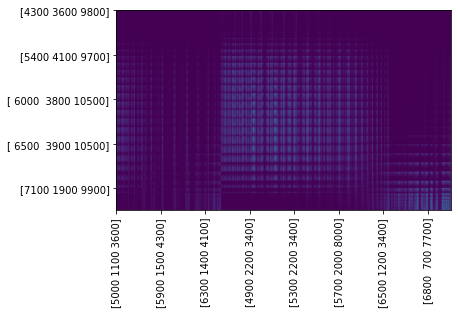

In [5]:
ax = plt.figure().gca()
ax.imshow(con_strength)

xticks = numpy.arange(0, len(coords_tgt), 1000)
yticks = numpy.arange(0, len(coords_src), 1000)
ax.set_xticks(xticks)
_ = ax.set_xticklabels(coords_tgt[xticks, :], rotation='vertical')
ax.set_yticks(yticks)
_ = ax.set_yticklabels(coords_src[yticks, :])

The coordinates it returns are the coordinates (in um) of the brain atlas, i.e. of the Allen common coordinate framework. But we can also apply transformations to these coordinates. For example, we can project them to 2d using a flat map.

While we could do that manually, there is a more convenient way. "FlattenedProjections" is a class derived from "CachedProjections" that you can associate with transformations to apply to source and / or target coordinates. These transformations have to be specified in the form of an class derived from voxel_maps.GeneralMap. One such class is the "Flatmap", which is instantiated by pointing it at a flatmap in .nrrd format. 

We instantiate such a "Flatmap" and build a "FlattenedProjections" that applies the flatmap to both source and target coordinates. Then we repeat the example above, but this time note that the returned coordinates are 2d only.

Coordinates are 2- and 2-dimensional


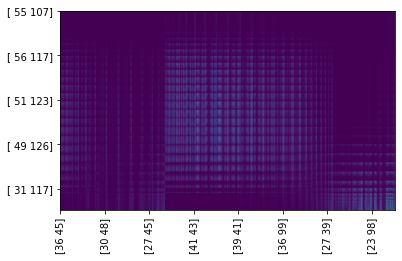

In [6]:
fm = Flatmap(path_to_example_flatmap)
FP = FlattenedProjections(cache_file=hdf5_cache, flatmap_source=fm, flatmap_target=fm)
con_strength, coords_src, coords_tgt = FP.projection(example_srcs, example_tgts)

print("Coordinates are {0}- and {1}-dimensional".format(coords_src.shape[1], coords_tgt.shape[1]))

ax = plt.figure().gca()
ax.imshow(con_strength)

xticks = numpy.arange(0, len(coords_tgt), 1000)
yticks = numpy.arange(0, len(coords_src), 1000)
ax.set_xticks(xticks)
_ = ax.set_xticklabels(coords_tgt[xticks, :], rotation='vertical')
ax.set_yticks(yticks)
_ = ax.set_yticklabels(coords_src[yticks, :])

Next, we explore the functionality in "voxel_maps" that let's us understand the topographical organization of a projection.

Understanding the topographical organization is equivalent to answering the following question: For any given voxel in the target region(s), which _part_ of the source region(s) is it preferably innervated by? 

The function voxel_maps.innervation_location tries to answer this as follows: For each voxel _tgt_ in the target region(s) it calculated a weighted mean of the coordinates of all source voxels _src_, where the weight is proportional to the connection strength from _src_ to _tgt_. 

The second output of the function (coords_for_mean_vol) is simply a repetition of "coords_target".

In the next cell, we run this analysis and then do a very primitive visualization of the results. Don't worry, later on we will do much better visualizations.

Note: You can also specify view="source" for this and all future analyses. In that case the role of "source" and "target" region are swapped, i.e. you consider the organization of innervation of "target" in "source". But for the purpose of these illustrations, we will stick to view="target".

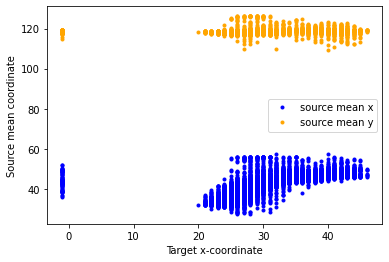

In [7]:
mean_vol, coords_for_mean_vol = innervation_location(con_strength, coords_src, coords_tgt, view="target")
plt.plot(coords_for_mean_vol[:, 0], mean_vol[:, 0], '.', color='blue', label='source mean x')
plt.plot(coords_for_mean_vol[:, 0], mean_vol[:, 1], '.', color='orange', label='source mean y')
plt.gca().set_xlabel("Target x-coordinate")
plt.gca().set_ylabel("Source mean coordinate")
plt.legend()

One much better visualization is provided by "innervation_image".
It takes the output of "innervation_location" and puts the result into a numpy.array. The exact shape of this array depends on whether or not the source and target coordinates were flattened. 

If the target coordinates were flattened (i.e. 2d), then it is a 3d array. If they were not flattened (i.e. 3d), then it is a 4d array. Generally, the number of dimensions is one higher than the number of dimensions of the target coordinates. That is, because the first _n_ dimensions correspond to the dimensions of the target coordinates. 

The last coordinate then encodes the mean source coordinates. The length of this dimension is equal to the number of dimensions of the source coordinates.

Example: For flattened source and target coordinates, the entry at [i, j, k] is the _k_ th mean source coordinate of the target voxel at (rounded) coordinates (_i_ , _j_ ), for 0 <= k < 2.

One purpose of this representation is to visualize it as an image, which we will do in the next cell.



/gpfs/bbp.cscs.ch/home/guyonnet/venvs/my_venv/lib/python3.7/site-packages/voxel_maps/voxel_mapping.py:47: RuntimeWarning: invalid value encountered in true_divide
  img_out = img_out / counts_out


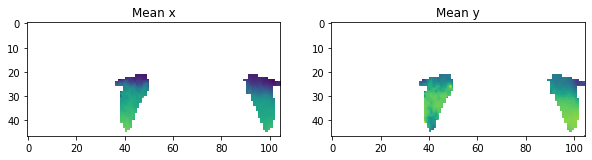

In [8]:
img_data = innervation_image(con_strength, coords_src, coords_tgt, view="target")
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(img_data[:, :, 0])
_ = ax.set_title("Mean x")
ax = fig.add_subplot(1, 2, 2)
ax.imshow(img_data[:, :, 1])
_ = ax.set_title("Mean y")

We see that there is a clear structure to the projection!

As mentioned above, we can also generate a corresponding view of the source region based on what parts of the target region(s) it innervates, by setting view="source". The next cell illustrates that.

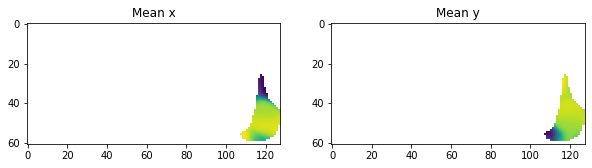

In [9]:
img_data = innervation_image(con_strength, coords_src, coords_tgt, view="source")
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(img_data[:, :, 0])
_ = ax.set_title("Mean x")
ax = fig.add_subplot(1, 2, 2)
ax.imshow(img_data[:, :, 1])
_ = ax.set_title("Mean y")

Now let's visualize the organization of this projection in a single image, as has been done in the "white matter" paper (Reimann et al., 2019).

In that paper, we placed a triangle in the flattened version of a source region. This defined a barycentric coordinate system whose coordinates are defined by how close they are to each of the points of the triangle. This turns 2d flattened coordinates into 3d coordinates, that can be interpreted and visualized as a RGB color. We therefore call these the "color coordinates" of a region.

We use the class "IrregularGridMapper" to define that triangle. It takes as input the coordinates of the voxels of the source region and places the three points of the triangle at the locations furthest away from the center of the region. It then exposes the transformation from 2d flat coordinates to 3d coordinates as the .col() function. 

As before, we turn the output of that transformation into an image plot. But since the source coordinates are now 3d, the output has the shape X x Y x 3, which can be interpreted by matplotlib as an RGB image! Neat!

We see in the image that each corner of the source region has a different color. If a pixel is red it means that it is very close to the corner of the triangle associated with the first coordinate (as "red" comes first in RGB).

The resulting triangle points are: (25.0, 117.0), (53.0, 127.0), (58.0, 108.0)


D:\ProgramData\Anaconda\envs\py37\lib\site-packages\voxel_maps\voxel_mapping.py:47: RuntimeWarning: invalid value encountered in true_divide
  img_out = img_out / counts_out


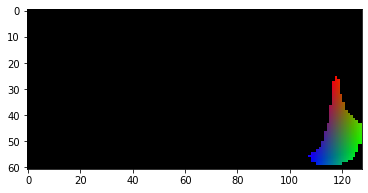

In [8]:
bary = IrregularGridMapper(coords_src, contract=1.0)
print("The resulting triangle points are: {0}, {1}, {2}".format(*zip(bary.x, bary.y)))

# Now get the "colors" associated with each point by transforming them.
# Inputs into this function are provided as separate x, y, z arguments. This is inconsistent with the rest. I apologize.
cols_src = bary.col(*coords_src.transpose())  

img_src = coordinates_to_image(cols_src, coords_src)
plt.imshow(img_src)

Using this with the rest of the code base is easy! Just as a flat map defines a transformation from 3d to 2d coordinates, this operation defines a transformation from 2d coordinates back to (different) 3d coordinates!

We can simply wrap "bary" in a "BarycentricMap" object, which is derived from "GeneralMap", just as the "Flatmap" above. We can then _add_ the "BarycentricMap" to the "Flatmap", where the addition describes the concatenation of the two operations. That is: project from 3d cartesian coordinates into 2d flat coordinates and from there to 3d color coordinates. 

We can then give the resulting transformation to a "FlattenedProjection" to apply to the source coordinates. How convenient. Note how for the target coordinates we still only apply the flatmap. As a result, the returned "coords_src" are 3d, "coords_tgt" are 2d.

In [10]:
bary_map = BarycentricMap(bary)
# Should have called the kwarg "transformation_source" instead, since this is more than a flatmap. Apologies...
FB = FlattenedProjections(cache_file=hdf5_cache, flatmap_source=fm + bary_map, flatmap_target=fm)

con_strength, coords_src_col, coords_tgt = FB.projection(example_srcs, example_tgts)
print("Coordinates are {0}- and {1}-dimensional".format(coords_src_col.shape[1], coords_tgt.shape[1]))

Coordinates are 3- and 2-dimensional


Now we can visualize the organization of the projection in a single image!
As before, we use the "innervation_image" function. But now, instead of the flatmap source region coordinates, we provide the color coordinates. For the target region, we provide the flatmap coordinates.

As a result, we get for all parts of the flattened target region the mean color of the source voxels innervating it. The output can be interpreted and visualized as a RGB image that reveals the structure of the projection! 

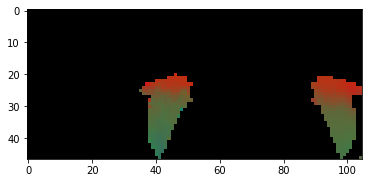

In [11]:
img_target = innervation_image(con_strength, coords_src_col, coords_tgt, view="target")
plt.imshow(img_target)

We can also visualize source and target in the same image. By default, the output of "innervation_image" is tight around the provided coordinates, thus the shape of the output is not yet compatible. To fix that, we have to explictly force the outputs to the same shape by providing the shape= argument.

NOTE: THIS DOES NOT WORK YET. I AM WORKING ON A FIX!

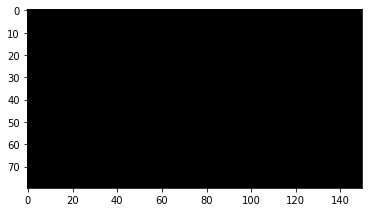

In [16]:
target_shape = (80, 150) # That should be large enough. If error, increase size
img_src = coordinates_to_image(cols_src, coords_src, shape=target_shape) 
img_target = innervation_image(con_strength, coords_src_col, coords_tgt, view="target", shape=target_shape)
plt.imshow(img_src + img_target)

Now everything I have demonstrated can be done for any combination of source and target regions. But it is even more flexible. Let me demonstrate some advanced features. 

First, as already mentioned. We can swap the roles of source and target easily.

Coordinates are 2- and 3-dimensional


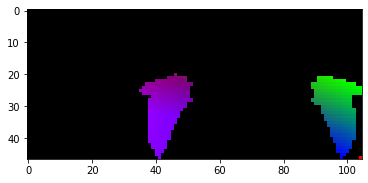

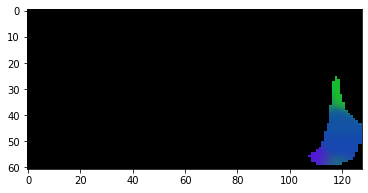

In [12]:
bary_tgt = IrregularGridMapper(coords_tgt, contract=1.0)
cols_tgt_reverse = bary_tgt.col(*coords_tgt.transpose())  

img_tgt_reverse = coordinates_to_image(cols_tgt_reverse, coords_tgt)
plt.figure()
plt.imshow(img_tgt_reverse)

bary_map_reverse = BarycentricMap(bary_tgt)
FB_reverse = FlattenedProjections(cache_file=hdf5_cache, flatmap_source=fm, flatmap_target=fm + bary_map_reverse)

con_strength, coords_src, coords_tgt_col = FB_reverse.projection(example_srcs, example_tgts)
print("Coordinates are {0}- and {1}-dimensional".format(coords_src.shape[1], coords_tgt_col.shape[1]))

img_target_reverse = innervation_image(con_strength, coords_src, coords_tgt_col, view="source")
plt.figure()
plt.imshow(img_target_reverse)

Another thing we can do: So far we visualized the organization of projections in the _flattened_ target region(s). But we do not have to flatten them! This is only done to be able to visualize the result.

If we want to study the organization in the actual three-dimensional target region, we can create a "FlattenedProjections" with flatmap_target=None. Now the target coordinates it puts out are the default, 3d cartesian coordinates.

After that, we can _still_ use the innervation_image function on the result. However, it will have four dimensions, which makes it hard to visualize. Here, I will just to a mean projection.

Coordinates are 3- and 3-dimensional
Resulting shape: (73, 29, 89, 3)


D:\ProgramData\Anaconda\envs\py37\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':


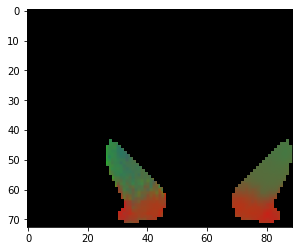

In [13]:
FB_nonflat = FlattenedProjections(cache_file=hdf5_cache, flatmap_source=fm + bary_map, flatmap_target=None)

con_strength, coords_src_col, coords_tgt_nonflat = FB_nonflat.projection(example_srcs, example_tgts)
print("Coordinates are {0}- and {1}-dimensional".format(coords_src_col.shape[1], coords_tgt_nonflat.shape[1]))

# To keep the resulting image small, we divide the coordinates by 100.
coords_tgt_nonflat = coords_tgt_nonflat / 100

img_target_nonflat = innervation_image(con_strength, coords_src_col, coords_tgt_nonflat, view="target")
print("Resulting shape: {0}".format(img_target_nonflat.shape))

plt.imshow(numpy.nanmean(img_target_nonflat, axis=1))

Finally, we can even generate "color coordinates" withput first flat mapping. Remember that the color coordinates are defined by a triangle. We can place the three points of the triangle in 3d space instead of the flattened 2d space! Conceptually, this still uses a flat map, but it is implicitly defined by the triangular coordinate system as follows: paralell project onto the plane defined by the triangle

Coordinates are 3- and 3-dimensional
Coordinates are 3- and 2-dimensional
Resulting shape: (47, 105, 3)


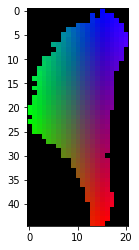

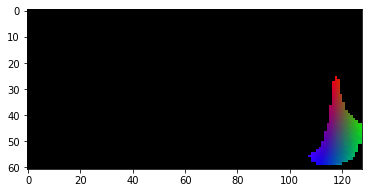

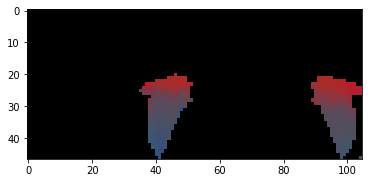

In [16]:
# Using "P" which does not use flat maps
con_strength, coords_src_nonflat, coords_tgt_nonflat = P.projection(example_srcs, example_tgts)

print("Coordinates are {0}- and {1}-dimensional".format(coords_src_nonflat.shape[1],
                                                        coords_tgt_nonflat.shape[1]))

# Creating coordinate system directly in the 3d source coordinates
bary_nonflat = IrregularGridMapper(coords_src_nonflat, contract=1.0)
cols_src_nonflat = bary_nonflat.col(*coords_src_nonflat.transpose())
# The object also exposes its "implied flatmap"
implied_flat_coords = bary_nonflat.implied_flatmap(*coords_src_nonflat.transpose())
# Output of the implied flatmap has negative entries. Subtract min to fix that.
# Also divide by 100 to keep the image smalle
implied_flat_coords = (implied_flat_coords - implied_flat_coords.min(axis=0)) / 100

img_src_nonflat = coordinates_to_image(cols_src_nonflat, implied_flat_coords)
plt.figure()
plt.imshow(img_src_nonflat)

# Alternative: Use the _colors_ gained from the nonflat barycentric coordinates, but turn them into an image with
# the regular flatmap coordinates (the second argument is different)
img_src_nonflat = coordinates_to_image(cols_src_nonflat, coords_src)
plt.figure()
plt.imshow(img_src_nonflat)

# Note: We use bary_nonflat only for the source coordinates that is had been optimized for.
# At the target we stick to the regular flatmap for now.
bary_nonflat_map = BarycentricMap(bary_nonflat)
FB_nonflat2 = FlattenedProjections(cache_file=hdf5_cache, flatmap_source=bary_nonflat_map, flatmap_target=fm)

con_strength, coords_src_col_nonflat, coords_tgt = FB_nonflat2.projection(example_srcs, example_tgts)
print("Coordinates are {0}- and {1}-dimensional".format(coords_src_col_nonflat.shape[1],
                                                        coords_tgt.shape[1]))

img_source_nonflat = innervation_image(con_strength, coords_src_col_nonflat, coords_tgt, view="target")
print("Resulting shape: {0}".format(img_source_nonflat.shape))

plt.figure()
plt.imshow(img_source_nonflat)


# Cortico-cortical Diffusion flatmap

In [ ]:
import json
import numpy
from voxel_maps import innervation_image, innervation_location, coordinates_to_image, GeneralMap, Flatmap, IrregularGridMapper, BarycentricMap
from projection_voxels import CachedProjections, FlattenedProjections
from matplotlib import pyplot as plt

In [17]:
import os
os.chdir('/gpfs/bbp.cscs.ch/home/guyonnet/flatmap_tools')
path_to_example_flatmap = "./notebook/diffusion_embedding_thalamic_flatmap_plus_isocortex_v2.nrrd"
allen_manifest = '../connectivity/voxel_model_manifest.json'
hdf5_cache = '../data/projection_h5_caches/all_proj.h5'

/gpfs/bbp.cscs.ch/home/guyonnet/venvs/my_venv/lib/python3.7/site-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


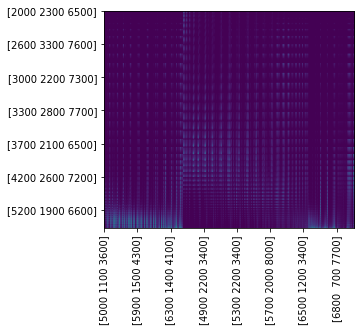

In [20]:
import os
import json
import numpy
from voxel_maps import innervation_image, innervation_location, coordinates_to_image, GeneralMap, Flatmap, IrregularGridMapper, BarycentricMap
from projection_voxels import CachedProjections, FlattenedProjections
from matplotlib import pyplot as plt
os.chdir('/gpfs/bbp.cscs.ch/home/guyonnet/flatmap_tools')
path_to_example_flatmap = "../data/cc_db_flatmap.nrrd"
allen_manifest = '../connectivity/voxel_model_manifest.json'
hdf5_cache = '../data/projection_h5_caches/all_proj.h5'
somatomotor = ["SSp-ll", "SSp-ul", "SSp-n", "SSp-m", "SSp-tr", "SSp-bfd",
                        "SSp-un", "SSs", "MOp", "MOs"]
cortex_regions = ["FRP","MOs","ACAd","ACAv","PL","ILA","ORBl","ORBm","ORBvl",
                             "AId","AIv","AIp","GU","VISC",
                             "SSs","SSp-bfd","SSp-tr","SSp-ll","SSp-ul","SSp-un","SSp-n","SSp-m","MOp",
                             "VISal","VISl","VISp","VISpl","VISli","VISpor","VISrl",
                             "VISa","VISam","VISpm","RSPagl","RSPd","RSPv",
                             "AUDd","AUDp","AUDpo","AUDv","TEa","PERI","ECT"]
example_srcs = ["MOs"]
example_tgts = ["SSp-ll", "SSp-ul", "SSp-tr"]
P = CachedProjections(cache_file=hdf5_cache)
con_strength, coords_src, coords_tgt = P.projection(example_srcs, example_tgts)
# connectivity matrix

ax = plt.figure().gca()
ax.imshow(con_strength)

xticks = numpy.arange(0, len(coords_tgt), 1000)
yticks = numpy.arange(0, len(coords_src), 1000)
ax.set_xticks(xticks)
_ = ax.set_xticklabels(coords_tgt[xticks, :], rotation='vertical')
ax.set_yticks(yticks)
_ = ax.set_yticklabels(coords_src[yticks, :])

Flatten into a 2 dimensional map

Coordinates are 2- and 2-dimensional


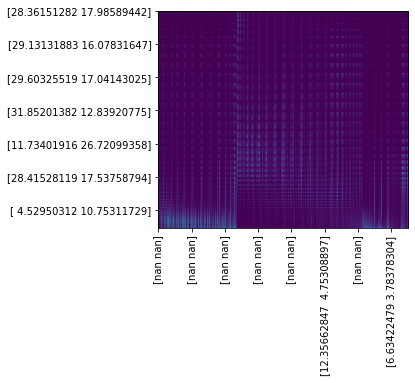

In [21]:
fm = Flatmap(path_to_example_flatmap)
FP = FlattenedProjections(cache_file=hdf5_cache, flatmap_source=fm, flatmap_target=fm)
con_strength, coords_src, coords_tgt = FP.projection(example_srcs, example_tgts)

print("Coordinates are {0}- and {1}-dimensional".format(coords_src.shape[1], coords_tgt.shape[1]))

ax = plt.figure().gca()
ax.imshow(con_strength)

xticks = numpy.arange(0, len(coords_tgt), 1000)
yticks = numpy.arange(0, len(coords_src), 1000)
ax.set_xticks(xticks)
_ = ax.set_xticklabels(coords_tgt[xticks, :], rotation='vertical')
ax.set_yticks(yticks)
_ = ax.set_yticklabels(coords_src[yticks, :])

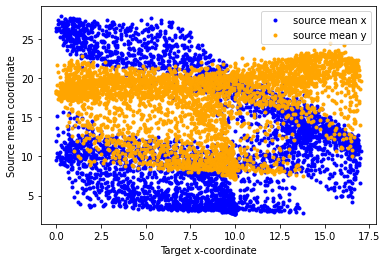

In [22]:
mean_vol, coords_for_mean_vol = innervation_location(con_strength, coords_src, coords_tgt, view="target")
plt.plot(coords_for_mean_vol[:, 0], mean_vol[:, 0], '.', color='blue', label='source mean x')
plt.plot(coords_for_mean_vol[:, 0], mean_vol[:, 1], '.', color='orange', label='source mean y')
plt.gca().set_xlabel("Target x-coordinate")
plt.gca().set_ylabel("Source mean coordinate")
plt.legend()

The resulting triangle points are: (20.0, 79.0), (62.0, 85.0), (59.0, 92.0)


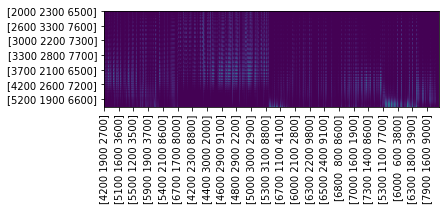

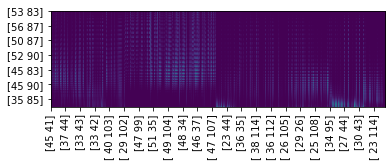

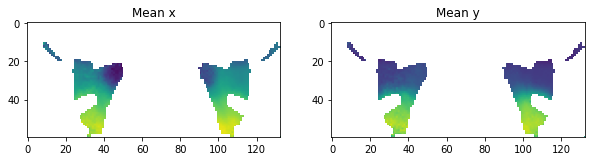

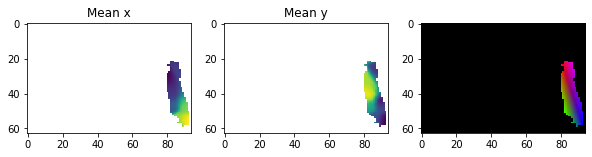

In [35]:
import os
os.chdir('/gpfs/bbp.cscs.ch/home/guyonnet/flatmap_tools')
path_to_example_flatmap = "./notebook/diffusion_embedding_thalamic_flatmap_plus_isocortex_v2.nrrd"
# path_to_example_flatmap = "./cc_db_flatmap_PP.nrrd"
# path_to_example_flatmap = "./cc_db_flatmap_1_3.nrrd"

hdf5_cache = '../data/projection_h5_caches/proj.h5'
cortex_regions = ["FRP","MOs","ACAd","ACAv","PL","ILA","ORBl","ORBm","ORBvl",
                             "AId","AIv","AIp","GU","VISC",
                             "SSs","SSp-bfd","SSp-tr","SSp-ll","SSp-ul","SSp-un","SSp-n","SSp-m","MOp",
                             "VISal","VISl","VISp","VISpl","VISli","VISpor","VISrl",
                             "VISa","VISam","VISpm","RSPagl","RSPd","RSPv",
                             "AUDd","AUDp","AUDpo","AUDv","TEa","PERI","ECT"]
example_srcs = ["MOs"] # Select the region
example_tgts = ["SSp-ul", "SSp-un", "SSp-m", 'SSp-tr', 'SSp-bfd', 'SSp-ll', 'VISrl', 'VISli']
# Use flat map to flatten the projection into 2d
P = CachedProjections(cache_file=hdf5_cache)
con_strength3, coords_src3, coords_tgt3 = P.projection(example_srcs, example_tgts)
ax = plt.figure().gca()
ax.imshow(con_strength3)
xticks = numpy.arange(0, len(coords_tgt3), 1000)
yticks = numpy.arange(0, len(coords_src3), 1000)
ax.set_xticks(xticks)
_ = ax.set_xticklabels(coords_tgt3[xticks, :], rotation='vertical')
ax.set_yticks(yticks)
_ = ax.set_yticklabels(coords_src3[yticks, :])

fm = Flatmap(path_to_example_flatmap)
FP = FlattenedProjections(cache_file=hdf5_cache, flatmap_source=fm, flatmap_target=fm)
con_strength, coords_src, coords_tgt = FP.projection(example_srcs, example_tgts)

coords_src = numpy.round(numpy.nan_to_num(coords_src, nan=-1)).astype(numpy.int64)
coords_tgt = numpy.round(numpy.nan_to_num(coords_tgt, nan=-1)).astype(numpy.int64)

ax = plt.figure().gca()
ax.imshow(con_strength)
xticks = numpy.arange(0, len(coords_tgt), 1000)
yticks = numpy.arange(0, len(coords_src), 1000)
ax.set_xticks(xticks)
_ = ax.set_xticklabels(coords_tgt[xticks, :], rotation='vertical')
ax.set_yticks(yticks)
_ = ax.set_yticklabels(coords_src[yticks, :])
#
# Other visualization
img_data = innervation_image(con_strength, coords_src, coords_tgt, view="target")
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(img_data[:, :, 0])
_ = ax.set_title("Mean x")
ax = fig.add_subplot(1, 2, 2)
ax.imshow(img_data[:, :, 1])
_ = ax.set_title("Mean y")
# Source region based on what parts of the target regions it innervates
img_data = innervation_image(con_strength, coords_src, coords_tgt, view="source")
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 3, 1)
ax.imshow(img_data[:, :, 0])
_ = ax.set_title("Mean x")
ax = fig.add_subplot(1, 3, 2)
ax.imshow(img_data[:, :, 1])
_ = ax.set_title("Mean y")

bary = IrregularGridMapper(coords_src, contract=1.0)
print("The resulting triangle points are: {0}, {1}, {2}".format(*zip(bary.x, bary.y)))

# Now get the "colors" associated with each point by transforming them.
# Inputs into this function are provided as separate x, y, z arguments. This is inconsistent with the rest. I apologize.
cols_src = bary.col(*coords_src.transpose())  
ax = fig.add_subplot(1, 3, 3)
img_src = coordinates_to_image(cols_src, coords_src)
plt.imshow(img_src)